In [1]:
import subprocess
import datetime
import os

import pandas as pd
from datetime import datetime


def gen_exec(cmd, check_return: bool = False):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line
    popen.stdout.close()
    return_code = popen.wait()
    if return_code and check_return:
        raise subprocess.CalledProcessError(return_code, cmd)


def exec_bash(cmd: str, check_return: bool = False):
    return [s for s in gen_exec(cmd.split(), check_return)]
    
def exec_bash_print(cmd: str, check_return: bool = False):
    for path in gen_exec(cmd.split(), check_return):
        print(path, end="")
        
def strtime():
    return datetime.now().strftime("%y%m%d_%H%M%S")



from pathlib import Path

prj_path = Path(str(Path("../../../").resolve())+"/")
exp_folder = Path(prj_path, "papers/neurips21/")
res_folder = Path(exp_folder, "output")
model_folder = Path(exp_folder, "models")

jar_file = Path(prj_path, "target/credici-0.1.3-SNAPSHOT-jar-with-dependencies.jar")
javafile = Path(exp_folder, "Experiments.java")
#java = "/Library/Java/JavaVirtualMachines/openjdk-12.0.1.jdk/Contents/Home/bin/java"
java = "java"


print(prj_path)
print(exp_folder)
print(res_folder)
print(model_folder)

print(jar_file)

/root/dev/credici
/root/dev/credici/papers/neurips21
/root/dev/credici/papers/neurips21/output
/root/dev/credici/papers/neurips21/models
/root/dev/credici/target/credici-0.1.3-SNAPSHOT-jar-with-dependencies.jar


In [2]:
# First results with 4 and 6
#labels = ["210517_185931", "210517_190132", "210517_190139", "210517_212428"] # 210517_161626

## markovian and quasi markovian larger modes
#labels = ["210519_182425", "210519_182654", "210519_182800"]

# first sequentials
labels = ["210520_195427", "210520_195439", "210520_194904"]

###############
# sets s0 s1a s1b
labels = ["210521_184054", "210521_184137", "210521_184122", "210522_060520", "210522_060542", "210522_060535"]
# s2 s2_2
labels += ["210523_131019", "210523_131014"]
#s2_3
labels += ["210523_170457"]

#sv0 sv1 #sv2

            
labels += [
           "210524_183436", #sv0    being repeated to include llk
           "210524_183454", #sv1   # being repeated to include llk
           "210524_183503"  #sv2
          ]



#sv0_2 sv1_2 #sv2_2
labels += [
            "210524_222459",  #sv0_2
            "210524_222512",   #sv1_2   # being repeated
            "210524_222523"  #sv2_2
            ]

## Repeated sv..

#labels += ["210527_193405", "210527_193410", #sv0 sv0_1
           #"210527_193414", "210527_193420",  #sv1 sv1_1
 #           "210527_201430", "210527_202518"#"210527_191434",  #sv1 sv1_1
 #         ]


# s1c s1c
labels += ["210525_081042", "210525_081050"]

#sq2 sq2_2 sq2_3 ... # timeout exception
labels += ["210526_172609","210526_172647","210526_172639"]


#############
#labels = ["210524_105434", "210524_131140", "210524_131149"]

In [3]:
from collections.abc import Iterable
import numpy as np


#def load_data():

F = [Path(res_folder, l) for l in labels] 

res_list = []

for output_folder in F:
    resfiles = [f for f in os.listdir(output_folder) if f.endswith(".py")]

    for r in resfiles:
        try:
            exec(Path(output_folder, r).read_text())
            res_list.append(results)
        except Exception:
            print(f"error in {r}")

print(len(res_list))



def to_pandas(res_dict):

    simple_cols = [c for c in res_dict.keys() if not isinstance(res_dict[c], Iterable) or isinstance(res_dict[c], str)]
    df1 = pd.DataFrame.from_dict({k:[res_dict[k]] for k in simple_cols})
    list_cols = [c for c in res_dict.keys() if c not in simple_cols]

    if len(list_cols)>1:
        df2 = pd.DataFrame.from_dict({k:res_dict[k] for k in list_cols})
        df = pd.concat([pd.concat([df1]*len(df2)).reset_index(drop=True), df2], axis=1)

    else:
        df = df1    

    df = df.reset_index(drop=False)
    df = df.rename(columns = dict(index="numPoints"))

    df["numPoints"] += 1

    df.columns

    columns = ['seed', 'markovian','error', 'nEndo','nExo', 'exoTW', 'errorMsg', 'folder', 'file', 'groundtruth',
              'timeBuild', 'timeExact', 'timeQuery',
              'pnsExact_l','pnsExact_u', 'pnsEM_l', 'pnsEM_u',  'numPoints','innerPoints', 'llkratio',
              'iterEM']

    columns = [c for c in columns if c in df.columns] + [c for c in df.columns if c not in columns]


    df = df[columns]
    return df

data = pd.concat([to_pandas(r) for r in res_list]).reset_index(drop=True)

# replace exact == -1 by NaN or None
data.loc[data.pnsExact_l == -1, "pnsExact_l"] = np.nan
data.loc[data.pnsExact_u == -1, "pnsExact_u"] = np.nan

# add exactEvaluable 

data["exact_eval"] = ~data["pnsExact_l"].isna()

# calculate RMSE


def rmse_pns(t): return np.sqrt((t["pnsEM_l"] - t["pnsExact_l"])**2 + (t["pnsEM_u"] - t["pnsExact_u"])**2)
def interval_size(t): return t["pnsExact_u"] - t["pnsExact_l"]
def get_type(t):
    if t["markovian"]:
        return "markovian"
    elif t["exoTW"]<2:
        return "quasi"
    else:
        return "non-quasi"
        

data["rmse_pns"] = data.apply(rmse_pns, axis=1)
data["interval_size"] = data.apply(interval_size, axis=1)
data["type"] = data.apply(get_type, axis=1)

data["id"] = (data["folder"] + "_"+ data["file"]).str.replace(".uai", "")

#    return data

#data = load_data()

#max iterations column
data = pd.merge(data, data[["id", "numPoints"]].groupby("id").max().rename(columns={"numPoints":"maxPoints"}), on="id")
data["timePerRun"] = data["timeBuild"]/data["maxPoints"] * data["numPoints"]


#mean ratio llk
data = pd.merge(data, data[["id", "llkratio"]].groupby("id").mean().rename(columns={"llkratio":"meanRatio"}), on="id")
data = pd.merge(data, data[["id", "llkratio"]].groupby("id").max().rename(columns={"llkratio":"maxRatio"}), on="id")
data = pd.merge(data, data[["id", "klpq"]].groupby("id").mean().rename(columns={"klpq":"meanklpq"}), on="id")


    
#data = data.loc[data.nEndo==7]


#data = data.loc[(data.meanRatio>=0.0) | (data.exoTW>1)]




error in s1b_chain_twExo1_nEndo15_19.uai_x20_pLAST_m200_s0.py
error in s1a_chain_twExo1_nEndo5_2.uai_x20_pLAST_m200_s0.py
error in s1a_2_chain_twExo1_nEndo5_21.uai_x20_pLAST_m200_s0.py
error in s1b_2_chain_twExo1_nEndo5_36.uai_x20_pLAST_m200_s0.py
461


<ipython-input-3-81535e621eae>:84: FutureWarning: The default value of regex will change from True to False in a future version.
  data["id"] = (data["folder"] + "_"+ data["file"]).str.replace(".uai", "")


In [4]:
data[["id", "meanklpq"]].groupby("id").mean()

,meanklpq
id,
s0_2_chain_twExo0_nEndo10_21,0.000576
s0_2_chain_twExo0_nEndo10_22,0.005195
s0_2_chain_twExo0_nEndo10_23,0.000411
s0_2_chain_twExo0_nEndo10_24,0.000482
s0_2_chain_twExo0_nEndo10_25,0.007503
...,...
sv2_chain_twExo2_nEndo7_5,NaN
sv2_chain_twExo2_nEndo7_6,NaN
sv2_chain_twExo2_nEndo7_7,NaN


Index(['seed', 'markovian', 'error', 'nEndo', 'nExo', 'exoTW', 'errorMsg',
       'folder', 'file', 'groundtruth', 'timeBuild', 'timeExact', 'timeQuery',
       'pnsExact_l', 'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints',
       'innerPoints', 'llkratio', 'iterEM', 'compatible', 'klpq', 'klsym',
       'klqp', 'exact_eval', 'rmse_pns', 'interval_size', 'type', 'id',
       'maxPoints', 'timePerRun', 'meanRatio', 'maxRatio', 'meanklpq'],
      dtype='object')

In [29]:
# plot RMSE vs numPoints
import matplotlib.pyplot as plt

# plot 3 a line for each nEndo

#df= data.loc[(data.markovian==True) & (data.exoTW==1)]
#df = data.loc[(data.markovian==False) & (data.exoTW==2)]
title=None
nEndo = [5,10]

def plot_rmse(df, title=None, nEndo = None, printVals=False):
    print(len(df[df.numPoints==1]))

    df = df[["folder","file", "numPoints", "rmse_pns", "exact_eval", "nEndo"]]
    
    print("=======")
    for t in df[df.numPoints==1].iterrows():
        print(f"{t[1]['folder']}/{t[1]['file']}")
        #print(t)
    print("=======")
    
    
    df = df.dropna()

    print(len(df[df.numPoints==1]))
    



    for n in nEndo:
        print(len(df.loc[(df.numPoints==1) & (df.nEndo==n)]))
        


    group_vars = ["numPoints"]

    if nEndo is not None: 
        group_vars +=  ["nEndo"]

    group = df[["numPoints", "rmse_pns", "exact_eval", "nEndo"]].groupby(group_vars)

    df = group.mean()

    fig, ax = plt.subplots()

    if nEndo is not None:
        df = df.reset_index()
        for n in nEndo:
            y = df[df.nEndo== n]["rmse_pns"]
            x = df[df.nEndo== n]["numPoints"]
            plt.plot(x,y, label=f"#endog = {int(n)}")

            if print:
                print()

                for t in np.vstack([x.values.T, y.values.T]).T:
                    print(f"{int(t[0])}\t{t[1]}")
                print()
    else:
        #print(df.columns)
        x = df["rmse_pns"]
        #print
        #y = df["numPoints"]

        plt.plot(x)


    ax.legend()

    ax.set(ylabel='RMSE', xlabel='EM runs',
           title=title, #ylim=[-0.01,0.05]
          )
    ax.grid()




133
s0/chain_twExo0_nEndo10_4.uai
s0/chain_twExo0_nEndo5_2.uai
s0/chain_twExo0_nEndo5_0.uai
s0/chain_twExo0_nEndo5_9.uai
s0/chain_twExo0_nEndo5_1.uai
s0/chain_twExo0_nEndo10_6.uai
s0/chain_twExo0_nEndo10_0.uai
s0/chain_twExo0_nEndo15_3.uai
s0/chain_twExo0_nEndo15_2.uai
s0/chain_twExo0_nEndo5_4.uai
s0/chain_twExo0_nEndo5_6.uai
s0/chain_twExo0_nEndo10_3.uai
s0/chain_twExo0_nEndo10_8.uai
s0/chain_twExo0_nEndo15_7.uai
s0/chain_twExo0_nEndo10_7.uai
s0/chain_twExo0_nEndo10_5.uai
s0/chain_twExo0_nEndo15_5.uai
s0/chain_twExo0_nEndo10_1.uai
s0/chain_twExo0_nEndo10_2.uai
s0/chain_twExo0_nEndo5_3.uai
s0/chain_twExo0_nEndo10_9.uai
s0/chain_twExo0_nEndo15_1.uai
s0/chain_twExo0_nEndo15_9.uai
s0/chain_twExo0_nEndo5_5.uai
s0/chain_twExo0_nEndo5_7.uai
s0/chain_twExo0_nEndo5_8.uai
s0/chain_twExo0_nEndo15_6.uai
s0/chain_twExo0_nEndo15_4.uai
s0/chain_twExo0_nEndo15_0.uai
s0/chain_twExo0_nEndo15_8.uai
s1b/chain_twExo0_nEndo10_14.uai
s1b/chain_twExo0_nEndo15_18.uai
s1b/chain_twExo0_nEndo10_10.uai
s1b/chain_

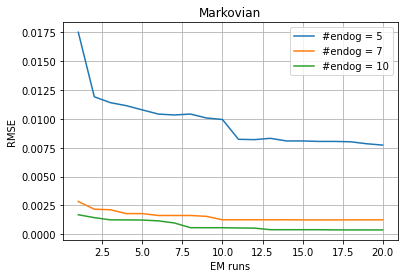

In [30]:
plot_rmse(data.loc[(data.markovian==True) & (data.exoTW==1)], nEndo = [5,7,10], title = "Markovian", printVals=True)
#data["exact_eval"]
#data.loc[(data.markovian==False) ]



In [8]:
data.columns

Index(['seed', 'markovian', 'error', 'nEndo', 'nExo', 'exoTW', 'errorMsg',
       'folder', 'file', 'groundtruth', 'timeBuild', 'timeExact', 'timeQuery',
       'pnsExact_l', 'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints',
       'innerPoints', 'llkratio', 'iterEM', 'compatible', 'klpq', 'klsym',
       'klqp', 'exact_eval', 'rmse_pns', 'interval_size', 'type', 'id',
       'maxPoints', 'timePerRun', 'meanRatio', 'maxRatio', 'meanklpq'],
      dtype='object')

112
s1b/chain_twExo1_nEndo15_18.uai
s1b/chain_twExo1_nEndo5_15.uai
s1b/chain_twExo1_nEndo15_16.uai
s1b/chain_twExo1_nEndo15_15.uai
s1b/chain_twExo1_nEndo15_17.uai
s1a/chain_twExo1_nEndo15_7.uai
s1a/chain_twExo1_nEndo15_3.uai
s1a/chain_twExo1_nEndo5_3.uai
s1a/chain_twExo1_nEndo5_4.uai
s1a/chain_twExo1_nEndo5_5.uai
s1a/chain_twExo1_nEndo10_6.uai
s1a/chain_twExo1_nEndo10_8.uai
s1a/chain_twExo1_nEndo15_8.uai
s1a_2/chain_twExo1_nEndo10_27.uai
s1a_2/chain_twExo1_nEndo15_28.uai
s1a_2/chain_twExo1_nEndo10_22.uai
s1a_2/chain_twExo1_nEndo15_22.uai
s1a_2/chain_twExo1_nEndo10_26.uai
s1a_2/chain_twExo1_nEndo5_27.uai
s1a_2/chain_twExo1_nEndo5_24.uai
s1a_2/chain_twExo1_nEndo5_26.uai
s1a_2/chain_twExo1_nEndo10_29.uai
s1a_2/chain_twExo1_nEndo5_22.uai
s1a_2/chain_twExo1_nEndo15_23.uai
s1a_2/chain_twExo1_nEndo10_28.uai
s1a_2/chain_twExo1_nEndo15_29.uai
s1a_2/chain_twExo1_nEndo5_28.uai
s1a_2/chain_twExo1_nEndo5_29.uai
s1a_2/chain_twExo1_nEndo10_21.uai
s1b_2/chain_twExo1_nEndo15_33.uai
s1b_2/chain_twExo1_n

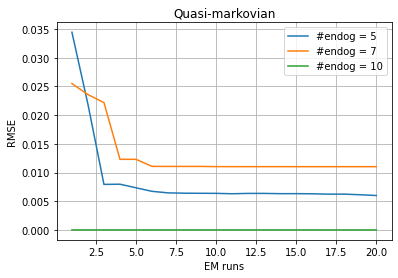

In [31]:
plot_rmse(data.loc[(data.markovian==False)  & (data.exoTW==1) & ((data.nEndo > 0))],
          #split_endo=False,
          title = "Quasi-markovian",
          nEndo = [5,7,10], printVals=True)




In [10]:
sum([29,33,18,20,33,25])

158

215
s2/chain_twExo2_nEndo15_17.uai
s2/chain_twExo2_nEndo5_18.uai
s2/chain_twExo2_nEndo5_1.uai
s2/chain_twExo2_nEndo15_10.uai
s2/chain_twExo2_nEndo5_5.uai
s2/chain_twExo2_nEndo5_6.uai
s2/chain_twExo2_nEndo15_19.uai
s2/chain_twExo2_nEndo5_19.uai
s2/chain_twExo2_nEndo15_8.uai
s2/chain_twExo2_nEndo5_8.uai
s2/chain_twExo2_nEndo15_6.uai
s2/chain_twExo2_nEndo5_13.uai
s2/chain_twExo2_nEndo15_2.uai
s2/chain_twExo2_nEndo5_17.uai
s2/chain_twExo2_nEndo15_9.uai
s2/chain_twExo2_nEndo15_5.uai
s2/chain_twExo2_nEndo15_15.uai
s2/chain_twExo2_nEndo5_2.uai
s2/chain_twExo2_nEndo15_3.uai
s2/chain_twExo2_nEndo5_12.uai
s2/chain_twExo2_nEndo5_15.uai
s2/chain_twExo2_nEndo15_4.uai
s2/chain_twExo2_nEndo15_13.uai
s2/chain_twExo2_nEndo5_3.uai
s2/chain_twExo2_nEndo5_10.uai
s2/chain_twExo2_nEndo15_14.uai
s2/chain_twExo2_nEndo5_9.uai
s2/chain_twExo2_nEndo15_18.uai
s2/chain_twExo2_nEndo5_7.uai
s2/chain_twExo2_nEndo15_16.uai
s2/chain_twExo2_nEndo5_4.uai
s2/chain_twExo2_nEndo5_16.uai
s2/chain_twExo2_nEndo15_12.uai
s2/cha

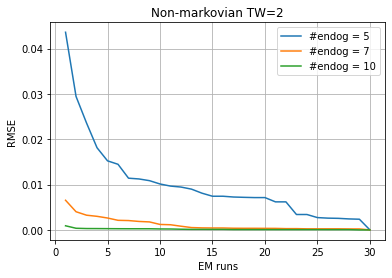

In [32]:
plot_rmse(data.loc[(data.markovian==False) & (data.exoTW==2)],  
          nEndo = [5,7,10], 
          title="Non-markovian TW=2", printVals=True)



In [12]:
195+132+133

460

markovian
[0.01625261 0.00319382 0.00219375]
non-quasi
[0.05358728 0.00778531 0.00109947]
quasi
[3.26249581e-02 3.44368311e-02 1.94271142e-05]


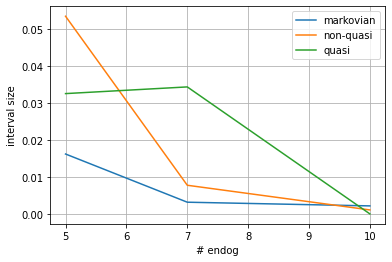

In [29]:
df = data.loc[data.nEndo<15]
df = df[["interval_size", "type", "nEndo"]].dropna()

group = df.groupby(["nEndo", "type"])
df = group.mean().reset_index()
fig, ax = plt.subplots()

vals = []

for t in df["type"].unique():
    y = df[df.type== t]["interval_size"]
    x = df[df.type== t]["nEndo"]
    plt.plot(x,y, label=f"{t}")
    
    print(t)
    print(y.values)
    #vals.append(y.values)

ax.legend()


#print(np.array(vals).T)

ax.set(ylabel='interval size', xlabel='# endog',
       title=title)
ax.grid()


markovian
[ 18.77580809  62.80384501 242.83345227]
non-quasi
[ 23.08661797  73.37517647 319.31441885]
quasi
[ 11.14036452  28.69073882 108.80902865]


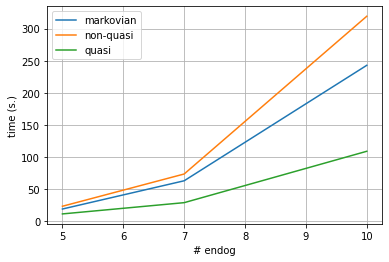

In [20]:
df = data.loc[data.nEndo<15]
df = df[["timePerRun", "type", "nEndo"]].dropna()

group = df.groupby(["nEndo", "type"])
df = group.mean().reset_index()
fig, ax = plt.subplots()

#l = {"markvovian":"Markovian", "quasi":"Quasi-Markovian", "non-quasi":"Non-Quasi-Markovian"}
vals = dict()

for t in df["type"].unique():
    y = df[df.type== t]["timePerRun"]/1000
    x = df[df.type== t]["nEndo"]
    plt.plot(x,y, label=f"{t}")
    
    print(t)
    print(y.values)

ax.legend()

ax.set(ylabel='time (s.)', xlabel='# endog',
       title=title)
ax.grid()


In [403]:



#df = data.loc[(data.nEndo<15) & (data.type != "non-quasi")]
def plot_under_th(data, nEndo = (5,7,10,15), th=0.01, title=None):
    df = data
    df["under_th"] = df["rmse_pns"]<th
    df = df[["under_th", "numPoints", "nEndo"]].dropna()


    stats = pd.DataFrame(columns = ["numPoints", "nEndo", "under_th"])

    for p in list(df.numPoints.unique()):
        for n in nEndo:
            M = len(df[(df.numPoints==p) & (df.nEndo==n) & (df.under_th==True)])
            N = len(df[(df.numPoints==p) & (df.nEndo==n)])

            if N>0:
                #print(f"{M}/{N}")

                stats = stats.append(dict(numPoints=p, nEndo=n, under_th=M/N*100), ignore_index=True)
    stats = stats.sort_values("numPoints")

    fig, ax = plt.subplots()

    df = df.reset_index()

    for n in nEndo:
        y = stats[stats.nEndo== n]["under_th"]
        x = stats[stats.nEndo== n]["numPoints"]
        plt.plot(x,y, label=f"#endog = {int(n)}")


    ax.legend()

    ax.set(ylabel='% models', xlabel='# endog',
           title=title)
    ax.grid()

<ipython-input-365-5ca6e57869ed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["under_th"] = df["rmse_pns"]<th


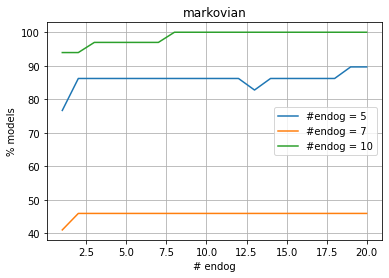

In [366]:

th = 0.01
plot_under_th(data.loc[(data.type == "markovian")],
              nEndo = [5,7,10],
              th = th,
              title="markovian")

<ipython-input-365-5ca6e57869ed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["under_th"] = df["rmse_pns"]<th


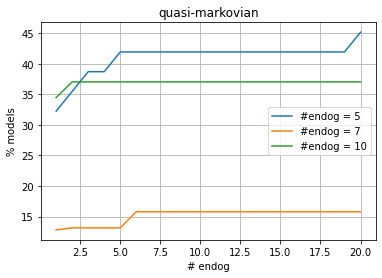

In [367]:
plot_under_th(data.loc[(data.type == "quasi")],
              nEndo = [5,7,10],
              th = th,
              title="quasi-markovian")

<ipython-input-365-5ca6e57869ed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["under_th"] = df["rmse_pns"]<th


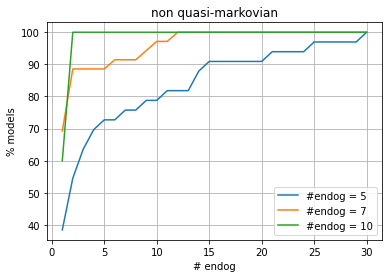

In [368]:
plot_under_th(data.loc[(data.type == "non-quasi")],
              nEndo = [5,7,10],
              th = th,
              title="non quasi-markovian")

In [247]:
llk_info = pd.concat(
    [group.mean().rename(columns=dict(llkratio="avg_llkratio")),
     group.min().rename(columns=dict(llkratio="min_llkratio")),
     group.max().rename(columns=dict(llkratio="max_llkratio")),
    ],axis = 1)
     
    
llk_info = data[["id","markovian", "exoTW", "nEndo", "nExo", "exact_eval"]].groupby("id").mean().merge(llk_info, on="id")

llk_info

#llk_info.to_csv(Path(output_folder,"llk_info.csv"))

KeyError: 'id'

In [ ]:
sum(llk_info["exact_eval"]==True)

In [ ]:
sum(llk_info["exact_eval"]==False)

In [ ]:
## Average llk-ratio when data is compatible
llk_info.loc[llk_info.exact_eval==True, "avg_llkratio"].hist()

In [ ]:
## Average llk-ratio when data is not compatible
llk_info.loc[llk_info.exact_eval==False, "avg_llkratio"].hist()

In [15]:
## Average llk-ratio when data is compatible
llk_info.loc[(llk_info.exact_eval==True) & (llk_info.avg_llkratio>0.8), "avg_llkratio"].hist()

AttributeError: 'DataFrame' object has no attribute 'exact_eval'

In [16]:
## Average llk-ratio when data is compatible
llk_info.loc[(llk_info.exact_eval==False) & (llk_info.avg_llkratio>0.8), "avg_llkratio"].hist()

AttributeError: 'DataFrame' object has no attribute 'exact_eval'

In [21]:
-float("inf")

-inf

In [22]:
# KLpq, KLsym  for compatible vs not compatible and mark and quasi-mark
data.columns

Index(['seed', 'markovian', 'error', 'nEndo', 'nExo', 'exoTW', 'errorMsg',
       'folder', 'file', 'groundtruth', 'timeBuild', 'timeExact', 'timeQuery',
       'pnsExact_l', 'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints',
       'innerPoints', 'llkratio', 'iterEM', 'klpq', 'klsym', 'klqp',
       'exact_eval', 'rmse_pns', 'id'],
      dtype='object')

In [23]:
group = data[["id", 'klpq', 'klsym', 'klqp']].groupby("id")
kl_info = group.mean()
kl_info = data[["id","markovian", "exoTW", "nEndo", "nExo", "exact_eval"]].groupby("id").mean().merge(kl_info, on="id")
kl_info

,exoTW,nEndo,nExo,exact_eval,klpq,klsym,klqp
id,,,,,,,
set1_chain_twExo0_nEndo4_10,1.0,4.0,4.0,True,0.000698,0.001294,0.000596
set1_chain_twExo0_nEndo4_16,1.0,4.0,4.0,True,0.000530,0.001069,0.000538
set1_chain_twExo0_nEndo4_17,1.0,4.0,4.0,True,0.000826,0.001604,0.000778
set1_chain_twExo0_nEndo4_18,1.0,4.0,4.0,True,0.000222,0.000444,0.000222
set1_chain_twExo0_nEndo4_2,1.0,4.0,4.0,True,0.000834,0.001679,0.000846
...,...,...,...,...,...,...,...
set3_chain_twExo3_nEndo6_3,3.0,6.0,6.0,True,0.003712,0.007408,0.003696
set3_chain_twExo3_nEndo6_6,3.0,6.0,6.0,True,0.002410,0.004724,0.002314
set3_chain_twExo3_nEndo6_7,NaN,NaN,NaN,False,NaN,NaN,NaN


<AxesSubplot:>

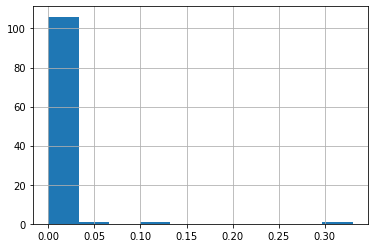

In [24]:
kl_info.loc[llk_info.exact_eval==True, "klpq"].hist()

<AxesSubplot:>

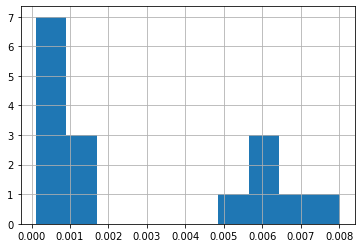

In [25]:
kl_info.loc[llk_info.exact_eval==False, "klpq"].hist()

In [153]:
i=3
data[data.groundtruth == "saturation"][['pnsExact_l',
       'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints', 'klpq', 'llkratio']].iloc[i*20:i*20+20]

,pnsExact_l,pnsExact_u,pnsEM_l,pnsEM_u,numPoints,klpq,llkratio
120,0.000301,0.002791,0.001974,0.001974,1,0.006496,0.973080
121,0.000301,0.002791,0.001974,0.002767,2,0.005738,0.976149
122,0.000301,0.002791,0.000301,0.002767,3,0.008010,0.967015
123,0.000301,0.002791,0.000301,0.002767,4,0.004603,0.980774
124,0.000301,0.002791,0.000301,0.002767,5,0.004695,0.980398
125,0.000301,0.002791,0.000301,0.002767,6,0.006142,0.974513
126,0.000301,0.002791,0.000301,0.002767,7,0.002760,0.988385
127,0.000301,0.002791,0.000301,0.002767,8,0.003584,0.984969
128,0.000301,0.002791,0.000301,0.002767,9,0.001494,0.993678
129,0.000301,0.002791,0.000301,0.002767,10,0.003892,0.983696


In [154]:
data.columns

Index(['seed', 'markovian', 'error', 'nEndo', 'nExo', 'exoTW', 'errorMsg',
       'folder', 'file', 'groundtruth', 'timeBuild', 'timeQuery', 'pnsExact_l',
       'pnsExact_u', 'pnsEM_l', 'pnsEM_u', 'numPoints', 'innerPoints',
       'llkratio', 'iterEM', 'klpq', 'klsym', 'klqp', 'timeExact',
       'exact_eval', 'rmse_pns', 'id'],
      dtype='object')

In [ ]:
## copy all the used models